In [223]:
#!pip install spotpy
import spotpy

# Link BMI_CFE with Spotpy

In [229]:
import os
import sys
#from netCDF4 import Dataset
#from pathlib import Path
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import csv


In [225]:
import bmi_cfe
import cfe

## set up spotpy class

In [226]:
class spotpy_setup(object): 

    def __init__(self): 
        # setup calibration parameters
        self.params = [spotpy.parameter.Uniform('bb',0,21.94,optguess=16),
                       spotpy.parameter.Uniform('smcmax',0.20554,1,optguess=0.439), #maybe max = 0.5
                       spotpy.parameter.Uniform('satdk',0,0.000726,optguess=3.38e-6),
                       spotpy.parameter.Uniform('slop',0,1,optguess=0.01),
                       spotpy.parameter.Uniform('max_gw_storage',0.01,0.25,optguess=0.01),
                       spotpy.parameter.Uniform('expon',1,8,optguess=6.0),
                       spotpy.parameter.Uniform('Cgw',1.8e-6,1.8e-3),
                       spotpy.parameter.Uniform('K_lf',0,0.1),
                       spotpy.parameter.Uniform('K_nash',0,0.1),
                       ]
    
        # Load test comparison data (streamflow) from usgs data
        data = pd.read_csv('/Users/Sophie/Desktop/CUAHSI/CFE_Calibration/01022500-usgs-hourly.csv')
        self.obs_data = data['QObs_CAMELS(mm/h)'].values
        self.eval_dates = data['date'].values

        # define start time and end calibration period for usgs streamflow obs.
        cal_start_idx_usgs = np.where(self.eval_dates=='2007-10-01 00:00:00')
        self.eval_dates = self.eval_dates[cal_start_idx_usgs[0][0]:]
        self.obs_data = self.obs_data[cal_start_idx_usgs[0][0]:]

        cal_end_idx_usgs = np.where(self.eval_dates=='2013-09-30 23:00:00')
        self.eval_dates = self.eval_dates[:cal_end_idx_usgs[0][0]+1]
        self.obs_data = self.obs_data[:cal_end_idx_usgs[0][0]+1]
        
        print('###--------- usgs start date: ' + self.eval_dates[0] + '.---------')
        print('###--------- usgs end date: ' + self.eval_dates[-1] + '.---------')

        print('###---------- after defining usgs end date usgs length: ' +  str(len(self.obs_data)) + '.---------')

    def parameters(self):
        return spotpy.parameter.generate(self.params)
        
    def simulation(self,vector,config_file):
        self.cfemodel = bmi_cfe.BMI_CFE(config_file)
        print('###--------model succesfully setup----------###')
        self.cfemodel.initialize()
        print('###--------model succesfully initialized----------###')

        with open(self.cfemodel.forcing_file, 'r') as f:
            self.df_forcing = pd.read_csv(f)
        print(f"###----- forcing_file loaded:{self.cfemodel.forcing_file}. -----###")

        # define start time for nldas forcing and usgs streamflow obs.
        cal_start_idx_nldas = np.where(self.df_forcing['date']=='2007-10-01 00:00:00')
        self.df_forcing = self.df_forcing.iloc[cal_start_idx_nldas[0][0]:,:]

        cal_start_idx_usgs = np.where(self.eval_dates=='2007-10-01 00:00:00')
        self.eval_dates = self.eval_dates[cal_start_idx_usgs[0][0]:]
        self.obs_data = self.obs_data[cal_start_idx_usgs[0][0]:]

        # define calibration end time.  (repeating because need to )
        cal_end_idx_usgs = np.where(self.eval_dates=='2013-09-30 23:00:00')
        self.eval_dates = self.eval_dates[:cal_end_idx_usgs[0][0]+1]
        self.obs_data = self.obs_data[:cal_end_idx_usgs[0][0]+1]

        cal_end_idx_nldas = np.where(self.df_forcing['date'].values=='2013-09-30 23:00:00')
        self.df_forcing = self.df_forcing.iloc[:cal_end_idx_nldas[0][0]+1,:]
        
        print('###------nldas start date: ' + self.df_forcing['date'].values[0]+ "-----###")
        print('###------nldas end date: ' + self.df_forcing['date'].values[-1]+"-----###")
        print('###--------- usgs start date: ' + self.eval_dates[0] + '.---------')
        print('###--------- usgs end date: ' + self.eval_dates[-1] + '.---------')

        print('###-----after defining start date nldas length: ' +  str(len(self.df_forcing['date'].values))+"------###")
        print('###---------- after defining usgs end date usgs length: ' +  str(len(self.obs_data)) + '.---------')
        
        self.generated_param = vector
        print(f"###----------- parameters generated: {self.generated_param}.--------###")
        self.cfemodel.soil_params['bb']=vector[0]
        self.cfemodel.soil_params['smcmax']=vector[1]
        self.cfemodel.soil_params['satdk']=vector[2]
        self.cfemodel.soil_params['slop']=vector[3]
        self.cfemodel.max_gw_storage==vector[4]
        self.cfemodel.expon=vector[5]
        self.cfemodel.Cgw=vector[6]
        self.cfemodel.K_lf=vector[7]
        self.cfemodel.K_nash=vector[8]

        self.outputs=self.cfemodel.get_output_var_names()
        self.output_lists = {output:[] for output in self.outputs}

        for precip, pet in zip(self.df_forcing['total_precipitation'],self.df_forcing['potential_evaporation']):
            #print(f"###----------loaded precip, pet: {precip},{pet}.------------###")
            #sys.exit(1)
            self.cfemodel.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
            self.cfemodel.set_value('water_potential_evaporation_flux', pet)
            self.cfemodel.update()
        
            for output in self.outputs:
                self.output_lists[output].append(self.cfemodel.get_value(output))
           
        self.cfemodel.finalize()

        print(f'###----------output length: {len(self.output_lists["land_surface_water__runoff_volume_flux"])}.---------###')

        return self.output_lists['land_surface_water__runoff_volume_flux']

    def evaluation(self,evaldates=False):
        if evaldates:
            self.eval_dates_output = [pd.Timestamp(test.eval_dates[i]) for i in range(len(test.eval_dates))]
            return self.eval_dates_output
        else:
            print(f"###--------- double check - length of obs_data: {len(self.obs_data)}. -----------###")
            return self.obs_data

    def objectivefunction(self,simulation,evaluation, params=None):
        self.obj_function = spotpy.objectivefunctions.kge(evaluation,simulation)
        return self.obj_function

# Run Calibration for each CAMEL

In [227]:
# load basin list
with open("./basin_list_516.txt", "r") as f:
    basin_list = pd.read_csv(f, header=None)

In [ ]:
# define config dir
config_path = "/Users/Sophie/Desktop/CUAHSI/CFE_Calibration"

# define number of iterations
N = 10

# define start and end time

for i in range(basin_list.shape[0]): 
    if i == 1 : sys.exit(0)

    # get basin id
    g = basin_list[0][i]

    # load config file
    config_filename = 'cat_' + str(g) + '_bmi_config_cfe.json'
    config_file = os.path.join(config_path,config_filename)

    # set up spotpy class
    test = spotpy_setup(config_file)
    sampler = spotpy.algorithms.dds(test,dbname=str(g) + 'DDS',dbformat='csv')

    # run interations
    sampler.sample(N)

    # get results 
    results = sampler.getdata()

    # save results for each basin
    cal_result_file = str(g) + '_cal_results.npy'
    np.save(cal_result_file, results)

## Evaluate and Plot

In [212]:
print(f"max discharge: {np.max(np.array(test.output_lists['land_surface_water__runoff_depth']))} m/h.")
flux = np.max(np.array(test.output_lists['land_surface_water__runoff_volume_flux']))
print(f"max flux converted discharge: {flux/(3.28**3)*3600/(573.6*(10**6))*1000} mm/h.")

max discharge: 4393.994980129236 m/h.
max flux converted discharge: 3.5260714849511845 mm/h.


In [235]:
best = spotpy.analyser.get_best_parameterset(results)
best

Best parameter set:
bb=13.02, smcmax=0.8774, satdk=0.000577, slop=0.4558, max_gw_storage=0.2405, expon=5.203, Cgw=0.001139, K_lf=0.021, K_nash=0.05374


array([(13.02, 0.8774, 0.000577, 0.4558, 0.2405, 5.203, 0.001139, 0.021, 0.05374),
       (15.05, 0.846 , 0.000577, 0.4558, 0.2183, 6.14 , 0.001139, 0.021, 0.0384 ),
       (13.02, 0.869 , 0.000577, 0.4558, 0.2405, 5.203, 0.001139, 0.021, 0.05374),
       (13.02, 0.8774, 0.000577, 0.4558, 0.2405, 6.566, 0.001139, 0.021, 0.05374)],
      dtype={'names': ['parbb', 'parsmcmax', 'parsatdk', 'parslop', 'parmax_gw_storage', 'parexpon', 'parCgw', 'parK_lf', 'parK_nash'], 'formats': ['<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8', '<f8'], 'offsets': [8, 16, 24, 32, 40, 48, 56, 64, 72], 'itemsize': 420952})

In [ ]:
# define result dir
result_path = "/Users/Sophie/Desktop/CUAHSI/CFE_Calibration"


for i in range(basin_list.shape[0]): 
    if i == 1 : sys.exit(0)

    # get basin id
    g = basin_list[0][i]

    # load calibration results
    result_filename = str(g) + '_cal_results.npy'
    results = np.load(result_filename)
    
    # export best parameters and the correponding simulation results
    best_parameters = spotpy.analyser.get_best_parameterset(results)
    
    ojb_values=results['like1']
    best_obj_value=np.nanmax(ojb_values)
    best_index=np.where(ojb_values==best_obj_value)
    best_sim = spotpy.analyser.get_modelruns(results[best_index[0][0]])
    best_sim = np.array([best_sim[i] for i in range(len(best_sim))])

    best_run = {'best parameters': best_parameters, "best simulation results": best_sim}

    # best_filename = str(g) + 'best_param_results.csv'
    # w = csv.writer(open(best_filename, "w"))
    # for key, val in best_run.items():w.writerow([key, val])

    best_filename = str(g) + 'best_param_results.json'
    with open(best_filename, 'w', encoding='utf-8') as f:
        json.dump(best_filename, f, ensure_ascii=False, indent=4)

    # plot parameter trace
    paramtrace_png_filename = str(g) + 'param_trace.png'
    spotpy.analyser.plot_parametertrace(results,fig_name=paramtrace_png_filename)   



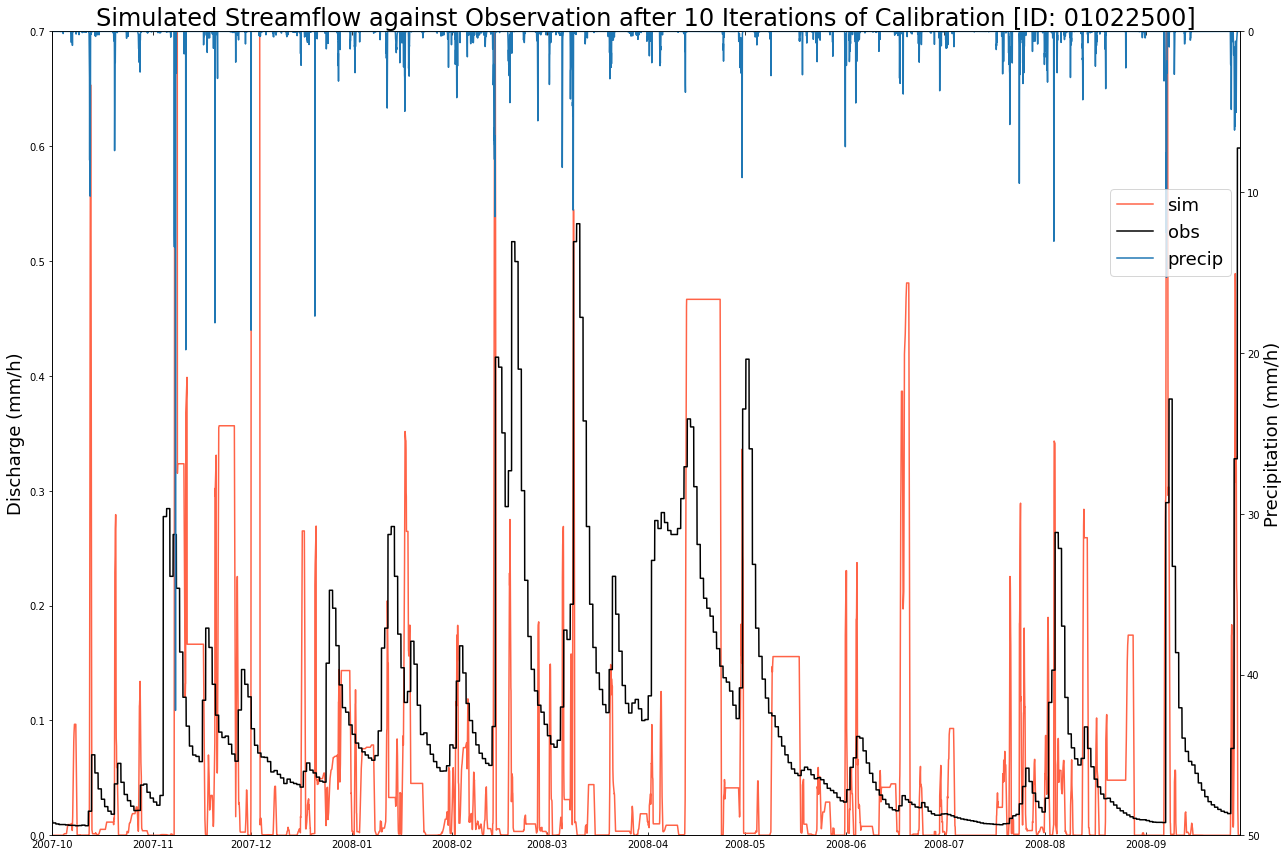

In [218]:
fig, ax1 = plt.subplots(figsize = (18,12)) 
p1, = ax1.plot(test.evaldates[0:8760],best_sim[0:8760]*3600/(3.28**3)/(573.6*(10**6))*1000,'tomato', label = "sim")
p2, = ax1.plot(test.evaldates[0:8760],test.obs_data[0:8760],'k',label = "obs")
ax1.set_ylabel('Discharge (mm/h)',fontsize = 18)
ax1.set_ylim([0,0.7])
ax1.margins(x=0)
ax1.xaxis.set_ticks_position('both')
ax1.xaxis.set_label_position('bottom')
ax1.tick_params(axis="x",direction="in")
ax2 = ax1.twinx()
p3, = ax2.plot(test.evaldates[0:8760],test.df_forcing["total_precipitation"][0:8760],'tab:blue', label = "precip")
ax2.set_ylim([50,0])
ax2.margins(x=0)
#ax2.invert_yaxis()
ax2.set_ylabel('Precipitation (mm/h)',fontsize = 18)
ax2.set_xlabel('Date', fontsize = 18)
plt.legend(handles = [p1,p2,p3],fontsize = 18, loc='right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))
plt.title('Simulated Streamflow against Observation after 10 Iterations of Calibration [ID: 01022500]', fontsize = 24)
plt.tight_layout()
plt.show()